# Calculate the nonstationary internal tide GP/spectral parameters

# Dask worker setup instructions

https://github.com/mrayson/pawsey-containers/tree/master/hpc-python/jupyter-sfoda

These settings do the job:

 1. `dask-scheduler --scheduler-file scheduler-$HOSTNAME.json --idle-timeout 0`
 2. `ssh localhost "cd /software/projects/pawsey0106/mrayson/projects && sbatch --time=04:00:00 --ntasks=64 -c 2 start_worker.slm scheduler-$HOSTNAME.json ./"`


In [1]:
hostname = !echo $(hostname)
hostname[0]

'nid002042'

In [2]:
import os
from distributed import Client
client=Client(scheduler_file='../../scheduler-' + hostname[0] + '.json')
client

Connection method: Scheduler file,Scheduler file: ../../scheduler-nid002042.json
Dashboard: http://10.253.133.92:8787/status,
Comm: tcp://10.253.133.92:8786,Workers: 0
Dashboard: http://10.253.133.92:8787/status,Total threads: 0
Started: 6 minutes ago,Total memory: 0 B


In [3]:
# client.restart() # This clears all data

In [4]:
import sfoda.suntans.sunxarray as sxr

import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cmocean import cm
from s3fs import S3FileSystem, S3Map

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-5ha9bt4v because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [5]:
s3login = '/home/mrayson/code/s3.acacia.login'

with open(s3login) as f:
    lines = f.readlines()

url, key, secret = [ff.strip('\n') for ff in lines[0:3]]
s3 = S3FileSystem(client_kwargs={'endpoint_url':url},
            key=key,
            secret=secret)


In [6]:
# import speccy
from scipy.optimize import minimize
from gptide import cov
from sfoda.utils.harmonic_analysis import getTideFreq

In [7]:
# Speccy stuff
def is_even(x):
    return x % 2 == 0

def n_freq(n):
    return int(np.floor(n/2))

def taus(n, delta):
    return delta * np.arange(n)

def fftshift(x):
    return np.fft.fftshift(x)

def fftfreq(n, delta):
    return fftshift(np.fft.fftfreq(n, delta))

def periodogram(ts, delta = 1, h = None):
    
    n = ts.size

    if h is not None:
        norm = np.sum(h**2)
        scale = np.sqrt(n/norm)
        ts = scale * h * ts

    dft = np.fft.fft(ts)/np.sqrt(n/delta)
    
    I = np.real(dft * np.conj(dft))
    ff = np.fft.fftfreq(n, delta)

    return fftshift(ff), fftshift(I)

def whittle(ts, specfunc, params, delta = 1, h = None):
    
    ff, I = periodogram(ts, delta, h)
    S = specfunc(ff, params)

    ll = - (np.log(S) + I/S)
    idx = (ff != 0) * (ff != -0.5/delta)
    
    return np.sum(ll[idx])

def dwhittle(ts, acffunc, params, delta = 1, h = None):
    
    tt = delta * np.arange(ts.size)
    ff, I = periodogram(ts, delta, h)
    ff_boch, S_boch = bochner(acffunc(tt, params), delta = delta, bias = True)
    # HACK: quick fix cause bochner isn't two sided yet
    return - 2 * np.sum(np.log(S_boch[ff_boch > 0]) + I[ff > 0]/S_boch[ff_boch > 0])

def bochner(acf, delta = 1, bias = True, h = None):

    n = np.size(acf)

    if h is not None:
        
        norm = np.sum(h**2)
        h_conv = (np.convolve(h, h, mode = 'full')/norm)[(n-1):]
        acf = h_conv * acf

    elif bias:

        acf = (1 - np.arange(n)/n) * acf

    ff = fftfreq(n, delta)

    if is_even(n):
        acf = np.concatenate([[acf[0]/2], acf[1:(n-1)], [acf[-1]/2]])
    else:
        acf = np.concatenate([[acf[0]/2], acf[1:n]])
    
    psd = 2 * delta * np.real(np.fft.fft(acf))

    return ff, fftshift(psd)

In [8]:
# Some functions that could also go into speccy...
def dwhittle_fast(x, y, ff, I, acffunc, params, delta = 1, h = None, fmin=0, fmax=np.inf):
    
    ff_boch, S_boch = bochner(acffunc(x, x[0], params), delta = delta, bias = True)
    
    # Subset frequencies
    idx_boch = (ff_boch > fmin) & (ff_boch<fmax)
    idx = (ff > fmin) & (ff<fmax)
    
    # HACK: quick fix cause bochner isn't two sided yet
    return - 2 * np.sum(np.log(S_boch[idx_boch]) + I[idx]/S_boch[idx_boch])

def myminfunc(params, priors, X, y, f, I, covfunc,  dt, fmin, fmax):
    ## Add on the priors
    
    sum_prior = 0.
    if priors is not None:
        log_prior = np.array([P.logpdf(val) for P, val in zip(priors, params)])
        if np.any(np.isinf(log_prior)):
            return 1e25
        sum_prior = np.sum(log_prior)
        
    return -dwhittle_fast(X, y, f, I, covfunc, params, delta=dt, fmin=fmin, fmax=fmax) - sum_prior

def estimate_spectral_params_whittle(y, X, covfunc, covparams_ic, fmin, fmax,
            priors=None,
            method='nelder-mead',
            options={'maxiter':5000},
            callback=None,
            bounds=None):

    # Compute the periodogram outside of
    dt = X[1]-X[0]

    f, I = periodogram(y, delta=dt)
    
    soln=minimize(myminfunc,
                  covparams_ic,
                  args=(priors, X, y, f, I, covfunc, dt, fmin, fmax),
                  method=method,
                  bounds=bounds,
                  options=options,
                  callback=callback,
                 )

    return soln['x']

def estimate_spectral_params_whittle_ufunc(y, priors=None, X=None, covfunc=None, covparams_ic=None, fmin=None, fmax=None, 
                                          method='nelder-mead',
                                          options={'maxiter':5000},
                                          callback=None,
                                          bounds=None):
    """
    Function that xarray.apply_func can handle
    """
    return estimate_spectral_params_whittle(y, X, covfunc, covparams_ic, fmin, fmax, 
                                            priors=priors,
                                            method=method, options=options, callback=callback, bounds=bounds)


#     def myminfunc(params, X, y, f, I, covfunc,  dt, fmin, fmax):
#     return -dwhittle_fast(X, y, f, I, covfunc, params, delta=dt, fmin=fmin, fmax=fmax)

#     def estimate_spectral_params_whittle(y, X, covfunc, covparams_ic, fmin, fmax,
#             method='nelder-mead',
#             options={'maxiter':5000},
#             callback=None,
#             bounds=None):

#     #print(y.shape, X.shape)

#     # Compute the periodogram outside of 
#     dt = X[1]-X[0]

#     #return y[0:len(covparams_ic)] # Testing

#     f, I = periodogram(y, delta=dt)

#     #return I[0:len(covparams_ic)] # Testing

#     #print(f.shape, I.shape)

#     soln=minimize(myminfunc, 
#                   covparams_ic,
#                   args=(X, y, f, I, covfunc, dt, fmin, fmax),
#                   method=method,
#                   bounds=bounds,
#                   options=options,
#                   callback=callback,
#                  ) 
#     #rint('done')

#     return soln['x']

#     # def estimate_spectral_params_whittle_ufunc(y, X=None, covfunc=None, covparams_ic=None, fmin=None, fmax=None):
#     #     """
#     #     Function that xarray.apply_func can handle
#     #     """
#     #     return estimate_spectral_params_whittle(y, X, covfunc, covparams_ic, fmin, fmax)

#     def estimate_spectral_params_whittle_ufunc(y, X=None, covfunc=None, covparams_ic=None, fmin=None, fmax=None, 
#                                           method='nelder-mead',
#                                           options={'maxiter':5000},
#                                           callback=None,
#                                           bounds=None):
#     """
#     Function that xarray.apply_func can handle
#     """
#     return estimate_spectral_params_whittle(y, X, covfunc, covparams_ic, fmin, fmax, 
#                                             method=method, options=options, callback=callback, bounds=bounds)



In [9]:
# Covariance kernels / ACFs

from scipy.special import kv as K_nu
from scipy.special import gamma

def logit(p, scale=1.):
    cff = 1/scale
    return np.log(p*cff/(1-p*cff))

def invlogit(x, scale=1.):
    return scale*np.exp(x)/(1+np.exp(x))

def calc_dist(x, xpr, eps=1e-14):
    dx2 = np.power(x-xpr, 2.)
    dx2[dx2<eps] = eps
    return np.sqrt(dx2)

def gamma_exp(x, xpr, gam, l):
    """γ-exponential covariance function"""
    dx = calc_dist(x, xpr)
    return np.exp(-np.power(dx/l, gam))
    
def matern_general(x, xpr, nu, l):
    """General Matern base function"""
    dx = calc_dist(x, xpr)
    
    cff1 = np.sqrt(2*nu)*dx/l
    #K = np.power(eta, 2.) * np.power(2., 1-nu) / gamma(nu)
    K = np.power(2., 1-nu) / gamma(nu)
    K *= np.power(cff1, nu)
    K *= K_nu(nu,cff1)
    
    #K[np.isnan(K)] = np.power(eta, 2.)
    
    return K

def oscillate_1d_matern(x, xpr, params):
    """
    1D Oscillatory kernel
    """
    eta, d, l, nu = params

    return eta**2 * matern_general(x, xpr, nu, d) * cov.cosine(x, xpr, l)

def oscillate_1d_gammaexp(x, xpr, params):
    """
    1D Oscillatory kernel
    """
    eta, d, l, gam = params

    return eta**2 * gamma_exp(x, xpr, gam, d) * cov.cosine(x, xpr, l)

def matern12(x,xpr,l):
    """Matern 1/2 base function"""
    fac2 = np.sqrt((x-xpr)*(x-xpr))
    return np.exp(-fac2/l)


def oscillate_1d(x, xpr, params, itfunc=matern12):
    """
    1D Oscillatory kernel
    """
    eta, d, l = params
    
    return eta**2 * itfunc(x, xpr, d) * cov.cosine(x, xpr, l)

def oscillate_M2S2(x, xpr, params, 
                     lt =[0.517525050851839, 0.5],
                       itfunc=matern12):

    eta1, d1, eta2, d2 = params
    
    C = oscillate_1d(x, xpr, (eta1, d1, lt[0]), itfunc=itfunc)
    C += oscillate_1d(x, xpr, (eta2, d2, lt[1]), itfunc=itfunc)

    return C

def oscillate_M2S2K1O1(x, xpr, params, 
                     lt =[0.517525050851839, 0.5, 0.9972695689985752, 1.0758059026974014],
                       itfunc=matern12):

    eta1, d1, eta2, d2, eta3, d3, eta4, d4 = params
    
    C = oscillate_1d(x, xpr, (eta1, d1, lt[0]), itfunc=itfunc)
    C += oscillate_1d(x, xpr, (eta2, d2, lt[1]), itfunc=itfunc)
    C += oscillate_1d(x, xpr, (eta3, d3, lt[2]), itfunc=itfunc)
    C += oscillate_1d(x, xpr, (eta4, d4, lt[3]), itfunc=itfunc)

    return C

def oscillate_M2S2K1O1_logeta(x, xpr, params, 
                     lt =[0.517525050851839, 0.5, 0.9972695689985752, 1.0758059026974014],
                       itfunc=matern12):

    log_eta1, log_d1, log_eta2, log_d2, log_eta3, log_d3, log_eta4, log_d4 = params
    
    eta1 = np.exp(log_eta1)
    eta2 = np.exp(log_eta2)
    eta3 = np.exp(log_eta3)
    eta4 = np.exp(log_eta4)
    
    d1 = np.exp(log_d1)
    d2 = np.exp(log_d2)
    d3 = np.exp(log_d3)
    d4 = np.exp(log_d4)

    C = oscillate_1d(x, xpr, (eta1, d1, lt[0]), itfunc=itfunc)
    C += oscillate_1d(x, xpr, (eta2, d2, lt[1]), itfunc=itfunc)
    C += oscillate_1d(x, xpr, (eta3, d3, lt[2]), itfunc=itfunc)
    C += oscillate_1d(x, xpr, (eta4, d4, lt[3]), itfunc=itfunc)

    return C

def oscillate_S2K1_logeta(x, xpr, params, 
                     lt =[ 0.5, 0.9972695689985752],
                       itfunc=matern12):

    log_eta1, log_d1, log_eta2, log_d2 = params
    
    eta1 = np.exp(log_eta1)
    eta2 = np.exp(log_eta2)
    
    
    d1 = np.exp(log_d1)
    d2 = np.exp(log_d2)

    C = oscillate_1d(x, xpr, (eta1, d1, lt[0]), itfunc=itfunc)
    C += oscillate_1d(x, xpr, (eta2, d2, lt[1]), itfunc=itfunc)

    return C

def oscillate_D2D1_logeta(x, xpr, params, 
                     lt =[ (0.5+0.517525050851839)/2, (0.9972695689985752+1.0758059026974014)/2],
                       itfunc=cov.matern32):

    log_eta1, log_d1, log_eta2, log_d2 = params
    
    eta1 = np.exp(log_eta1)
    eta2 = np.exp(log_eta2)
    
    
    d1 = np.exp(log_d1)
    d2 = np.exp(log_d2)

    C = oscillate_1d(x, xpr, (eta1, d1, lt[0]), itfunc=itfunc)
    C += oscillate_1d(x, xpr, (eta2, d2, lt[1]), itfunc=itfunc)

    return C

def oscillate_D2D1_logeta_constant(x, xpr, params, 
                     lt =[ (0.5+0.517525050851839)/2, (0.9972695689985752+1.0758059026974014)/2],
                       itfunc=cov.expquad):

    log_eta1, log_d1, log_eta2, log_d2, log_constant = params
    
    eta1 = np.exp(log_eta1)
    eta2 = np.exp(log_eta2)
    d1 = np.exp(log_d1)
    d2 = np.exp(log_d2)
    constant = np.exp(log_constant)

    C = oscillate_1d(x, xpr, (eta1, d1, lt[0]), itfunc=itfunc)
    C += oscillate_1d(x, xpr, (eta2, d2, lt[1]), itfunc=itfunc)
    C[0] = C[0] + constant

    return C

def oscillate_D2D1_gmatern(x, xpr, params, 
                     lt =[ (0.5+0.517525050851839)/2, (0.9972695689985752+1.0758059026974014)/2]):

    log_eta1, log_d1, log_eta2, log_d2, log_nu, log_constant = params
    
    eta1 = np.exp(log_eta1)
    eta2 = np.exp(log_eta2)
    d1 = np.exp(log_d1)
    d2 = np.exp(log_d2)
    nu = np.exp(log_nu)
    constant = np.exp(log_constant)

    C = oscillate_1d_matern(x, xpr, (eta1, d1, lt[0], nu))
    C += oscillate_1d_matern(x, xpr, (eta2, d2, lt[1], nu))
    
    C[0] = C[0] + constant

    return C

def oscillate_D2D1_gmatern2(x, xpr, params, 
                     lt =[ (0.5+0.517525050851839)/2, (0.9972695689985752+1.0758059026974014)/2]):

    log_eta1, log_d1, log_eta2, log_d2, logit_nu1, logit_nu2, log_constant = params
    
    eta1 = np.exp(log_eta1)
    eta2 = np.exp(log_eta2)
    d1 = np.exp(log_d1)
    d2 = np.exp(log_d2)
    
    nu1 = invlogit(logit_nu1, scale=3.5) # 0 < nu < 3.5
    nu2 = invlogit(logit_nu2, scale=3.5) # 0 < nu < 3.5 
    
    constant = np.exp(log_constant)

    C = oscillate_1d_matern(x, xpr, (eta1, d1, lt[0], nu1))
    C += oscillate_1d_matern(x, xpr, (eta2, d2, lt[1], nu2))
    
    C[0] = C[0] + constant

    return C


def oscillate_D2D1_legit(x, xpr, params, 
                     lt =[ (0.5+0.517525050851839)/2, (0.9972695689985752+1.0758059026974014)/2]):

    log_eta1, log_d1, log_eta2, log_d2, logit_gamma, log_constant = params
    
    eta1 = np.exp(log_eta1)
    eta2 = np.exp(log_eta2)
    d1 = np.exp(log_d1)
    d2 = np.exp(log_d2)
    
    gam = invlogit(logit_gamma, scale=2.) # 0 < gamma < 2
    constant = np.exp(log_constant)

    C = oscillate_1d_gammaexp(x, xpr, (eta1, d1, lt[0], gam))
    C += oscillate_1d_gammaexp(x, xpr, (eta2, d2, lt[1], gam))
    
    C[0] = C[0] + constant

    return C

def oscillate_D2D1_legit2(x, xpr, params, 
                     lt =[ (0.5+0.517525050851839)/2, (0.9972695689985752+1.0758059026974014)/2]):

    log_eta1, log_d1, log_eta2, log_d2, logit_gamma1, logit_gamma2, log_constant = params
    
    eta1 = np.exp(log_eta1)
    eta2 = np.exp(log_eta2)
    d1 = np.exp(log_d1)
    d2 = np.exp(log_d2)
    
    gam1 = invlogit(logit_gamma1, scale=2.) # 0 < gamma < 2
    gam2 = invlogit(logit_gamma2, scale=2.) # 0 < gamma < 2
    constant = np.exp(log_constant)

    C = oscillate_1d_gammaexp(x, xpr, (eta1, d1, lt[0], gam1))
    C += oscillate_1d_gammaexp(x, xpr, (eta2, d2, lt[1], gam2))
    
    C[0] = C[0] + constant

    return C

def oscillate_D2D1_gammaexp(x, xpr, params, 
                     lt =[ (0.5+0.517525050851839)/2, (0.9972695689985752+1.0758059026974014)/2]):

    eta1, d1, eta2, d2, gam1, gam2, constant = params
    

    C = oscillate_1d_gammaexp(x, xpr, (eta1, d1, lt[0], gam1))
    C += oscillate_1d_gammaexp(x, xpr, (eta2, d2, lt[1], gam2))
    
    C[0] = C[0] + constant

    return C

In [10]:
def save_load_chunk_old(ds, i1, i2):
    
    tmpfile = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/tmp.zarr'
    y = (ds['eta_steric_bandpass']-ds['eta_steric_tidal']).\
        sel(time=slice('2013-07-15','2014-07-01')).isel(Nc=slice(i1, i2))#.chunk({'Nc':1})##.chunk({'Nc':1})
    X = (y.time-y.time[0]).values.astype(float)/1e9/86400

    dsout = xr.Dataset({'y':y}) #
    dsout
    dsout['y'].encoding['chunks']={'chunks':(8425,100) }
    dsout['y'].encoding['preferred_chunks']={'time': 8425, 'Nc': 100},
    dsout.to_zarr(tmpfile, compute=True, mode='w')

    # ds = xr.load_dataset(tmpfile, engine='zarr', chunks={}).chunk({'Nc':1}) # This loads the data?
    dsnew = xr.load_dataset(tmpfile, engine='zarr').chunk({'Nc':1})

    #y_ = da.from_zarr(tmpfile, component='y')
    
    return dsnew['y'], X

def save_load_chunk(ds, i1, i2, varname):
    
    tmpfile = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/tmp.zarr'
    
    y = ds[varname].\
        sel(time=slice('2013-07-15','2014-07-01')).isel(Nc=slice(i1, i2))#.chunk({'Nc':1})##.chunk({'Nc':1})
    X = (y.time-y.time[0]).values.astype(float)/1e9/86400

    dsout = xr.Dataset({'y':y}) #
    dsout
    dsout['y'].encoding['chunks']={'chunks':(8425,100) }
    dsout['y'].encoding['preferred_chunks']={'time': 8425, 'Nc': 100},
    dsout.to_zarr(tmpfile, compute=True, mode='w')

    # ds = xr.load_dataset(tmpfile, engine='zarr', chunks={}).chunk({'Nc':1}) # This loads the data?
    dsnew = xr.load_dataset(tmpfile, engine='zarr').chunk({'Nc':1})

    #y_ = da.from_zarr(tmpfile, component='y')
    
    return dsnew['y'], X



In [24]:
###
# Inputs
# eta1 = 0.007
# eta2 = 0.008
# eta3 = 0.003
# eta4 = 0.006

# eta1 = np.log(0.007)
# # eta2 = np.log(0.008)
# eta2 = np.log(0.003)
# eta3 = np.log(0.003)
# eta4 = np.log(0.006)

# dt1 = np.log(10.)
# dt2 = np.log(10.) 
# dt3 = np.log(10.)
# dt4 = np.log(10.)

eta1 = 0.005
eta2 = 0.003
dt1 = 2.5
dt2 = 2.5

constant = np.log(1e-6)

gam1 = 1.5
gam2 = 1.5

# nu1 = 2.
# nu2 = 2.

# covfunc=oscillate_M2S2K1O1
# covfunc=oscillate_M2S2K1O1_logeta
# covfunc=oscillate_S2K1_logeta
# covfunc=oscillate_D2D1_logeta_constant
# covfunc=oscillate_D2D1_legit2
covfunc=oscillate_D2D1_gammaexp

# covfunc=oscillate_D2D1_gmatern2

# covfunc=oscillate_M2S2

# Frequencies to fit over
# fmin = 0.5
# fmax = 2.7
fmin = 0.7
# fmax = 2.2
# fmin = 0.8
fmax = 2.3

# outfile = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_logeta.zarr'
# outfile_nc = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_logeta.nc'
# outfile = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_seasonaltides_S2K1_v2.zarr'
# outfile_nc = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_seasonaltides_S2K1_v2.nc'

# outfile = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_seasonaltides_D2D1_v3.zarr'
# outfile_nc = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_seasonaltides_D2D1_v3.nc'
# outfile = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_seasonaltides_D2D1_eta.zarr'
# outfile_nc = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_seasonaltides_D2D1_eta.nc'

# outfile = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_astrotides_D2D1_eta.zarr'
# outfile_nc = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_astrotides_D2D1_eta.nc'
# outfile = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_astrotides_D2D1_vc.zarr'
# outfile_nc = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_astrotides_D2D1_vc.nc'
# outfile = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_astrotides_v2.zarr'
# outfile_nc = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_astrotides_v2.nc'
# outfile = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_astrotides_D2D1.zarr'
# outfile_nc = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_astrotides_D2D1.nc'

invarname = 'uc'
outfile = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_seasonaltides_D2D1_{}.zarr'.format(invarname)
outfile_nc = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_seasonaltides_D2D1_{}.nc'.format(invarname)

# zarrin = 'NWS_2km_GLORYS_2013_2014_ssh_steric_filtered_seasonaltides.zarr'
# zarrin = 'NWS_2km_GLORYS_2013_2014_ssh_steric_filtered_astrotides.zarr'
# varname = 'eta_steric_non_phase_locked'
# dropvars=['eta_steric_non_phase_locked','eta_steric_phase_locked']

# zarrin = 'NWS_2km_GLORYS_2013_2014_ssh_filtered_seasonaltides.zarr'
# zarrin = 'NWS_2km_GLORYS_2013_2014_ssh_filtered_astrotides.zarr'
# varname = 'eta_non_phase_locked'
# dropvars=['eta_non_phase_locked','eta_phase_locked']

zarrin = 'NWS_2km_GLORYS_2013_2014_{}_seasonaltides.zarr'.format(invarname)
varname = '{}_non_phase_locked'.format(invarname)
dropvars=['{}_non_phase_locked'.format(invarname),'{}_phase_locked'.format(invarname)]


# fmin = 1.6
# fmax = 2.2
# outfile = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_M2S2.zarr'
# outfile_nc = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_M2S2.nc'

# covparams = (eta1, dt1, eta2, dt2, eta3, dt3, eta4, dt4)
# paramnames = ['η1','ℓ1', 'η2','ℓ2','η3','ℓ3','η4','ℓ4']

# covparams = (eta1, dt1, eta2, dt2)
# paramnames = ['η1','ℓ1', 'η2','ℓ2']

# covparams = (eta1, dt1, eta2, dt2, constant)
# paramnames = ['η1','ℓ1', 'η2','ℓ2','c']

covparams = (eta1, dt1, eta2, dt2, gam1, gam2, constant)
paramnames = ['η1','ℓ1', 'η2','ℓ2','γ1','γ2', 'c']
bounds = [(1e-15, 1.), (1e-15, 15.), (1e-15, 1.), (1e-15, 15.), (1, 2-1e-15), (1, 2-1e-15),(1e-15, 1.)]


# covparams = (eta1, dt1, eta2, dt2, nu1, nu2, constant)
# paramnames = ['η1','ℓ1', 'η2','ℓ2','ν1','ν2', 'c']
#####


# Change notes:
 - v1 - v4: ?? I forgot to write notes
 - v5: tried l-bgfs-b optimizer
 - v6: included bounds, oscillate_D2D1_gammaexp covfunc, updated docker container...
 - v7: set propoer bounds for gamma (not = 2!!)
 - v8 : set proper initial conditions (not log)
 - _ssh: use raw eta (not steric as input)

In [25]:

f = S3Map("uwaoceanprocesses-suntans/"+zarrin, s3=s3)


ds = xr.open_dataset(f, engine='zarr', chunks={})

# These need filling in??
ds.suntans.xv=ds.xv.values
ds.suntans.yv=ds.yv.values

ds

Changing the _FillValue from -999999 to 999999


<xarray.Dataset>
Dimensions:              (Nc: 225368, numsides: 8, Nk: 80, time: 8761,
                          Np: 454016)
Coordinates:
  * time                 (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-0...
    z_r                  (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
Dimensions without coordinates: Nc, numsides, Nk, Np
Data variables:
    cells                (Nc, numsides) int32 dask.array<chunksize=(2000, 8), meta=np.ndarray>
    dv                   (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    dz                   (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    nfaces               (Nc) int32 dask.array<chunksize=(2000,), meta=np.ndarray>
    uc_non_phase_locked  (time, Nc) float64 dask.array<chunksize=(8761, 2000), meta=np.ndarray>
    uc_phase_locked      (time, Nc) float64 dask.array<chunksize=(8761, 2000), meta=np.ndarray>
    xp                   (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    xv                   (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    yp                   (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    yv                   (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
Attributes:
    Author:       mrayson
    Description:  SUNTANS surface fields

In [26]:
# Loop through in chunks
step = 10000
mode='w'
append_dim = None


for ii in range(0, ds.dims['Nc'], step):
    i1 = ii
    i2 = ii+step
    if i2 > ds.dims['Nc']:
        i2 = ds.dims['Nc']
    print(i1,i2, ds.dims['Nc'])
    
    print('\tSubsetting the data...')
    y, X = save_load_chunk(ds, i1, i2, varname)
    
    inputs = dict(X=X, covfunc=covfunc, covparams_ic=covparams, fmin=fmin, fmax=fmax,
                 method='nelder-mead',bounds=bounds)
    
    print('\tBuilding the dask graph...')
    params = xr.apply_ufunc(estimate_spectral_params_whittle_ufunc,
                          y,
                          dask='parallelized',
                          kwargs=inputs,
                          output_dtypes=[y.dtype],
                          input_core_dims=(['time',],),
                          output_core_dims=(['params'],),
                          #output_sizes=,
                          dask_gufunc_kwargs={'output_sizes':{'params':len(covparams)}},
                          vectorize=True,
                         )
    print('\tComputing parameters...')
    params = params.compute()
    
    #dsout = ds.drop_vars(['eta_steric_lowpass','eta_steric_bandpass','eta_steric_tidal']).isel(Nc=slice(i1,i2))
    

    dsout = ds.drop_vars(dropvars).isel(Nc=slice(i1,i2))
    
    dsout['data'] = params.chunk({'Nc':2000})
    dsout['data'].attrs = {'long_name':'Estimated covariance model parameters','location':'face',
                                     'parameter names':paramnames,
                          'covariance function':covfunc.__name__,
                           'input file':zarrin} 
    
    # dsout = xr.Dataset({'data':params})
    print('\tSaving output...')
    dsout.to_zarr(outfile, mode=mode, append_dim=append_dim, compute=True)
    append_dim='Nc'
    mode='a'
    print('\t\tDone.')

    #break

0 10000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 645.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
10000 20000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 645.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
20000 30000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 645.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
30000 40000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 645.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
40000 50000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 645.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
50000 60000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 645.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
60000 70000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 645.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
70000 80000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 645.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
80000 90000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 645.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
90000 100000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 645.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
100000 110000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 645.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
110000 120000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 645.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
120000 130000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 645.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
130000 140000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 645.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
140000 150000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 645.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
150000 160000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 645.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
160000 170000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 645.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
170000 180000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 645.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
180000 190000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 645.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
190000 200000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 645.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
200000 210000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 645.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
210000 220000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 645.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
220000 225368 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 346.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.


In [27]:
outfile, outfile_nc

('/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_seasonaltides_D2D1_uc.zarr',
 '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_seasonaltides_D2D1_uc.nc')

In [28]:
dsnew = xr.open_dataset(outfile, engine='zarr')

dsnew.to_netcdf(outfile_nc)
dsnew


<xarray.Dataset>
Dimensions:  (Nc: 225368, numsides: 8, params: 7, Nk: 80, time: 8761, Np: 454016)
Coordinates:
  * time     (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-07-01
    z_r      (Nk) float64 ...
Dimensions without coordinates: Nc, numsides, params, Nk, Np
Data variables:
    cells    (Nc, numsides) int32 ...
    data     (Nc, params) float64 ...
    dv       (Nc) float64 ...
    dz       (Nk) float64 ...
    nfaces   (Nc) int32 ...
    xp       (Np) float64 ...
    xv       (Nc) float64 ...
    yp       (Np) float64 ...
    yv       (Nc) float64 ...
Attributes:
    Author:       mrayson
    Description:  SUNTANS surface fields

In [29]:
%matplotlib notebook

<IPython.core.display.Javascript object>


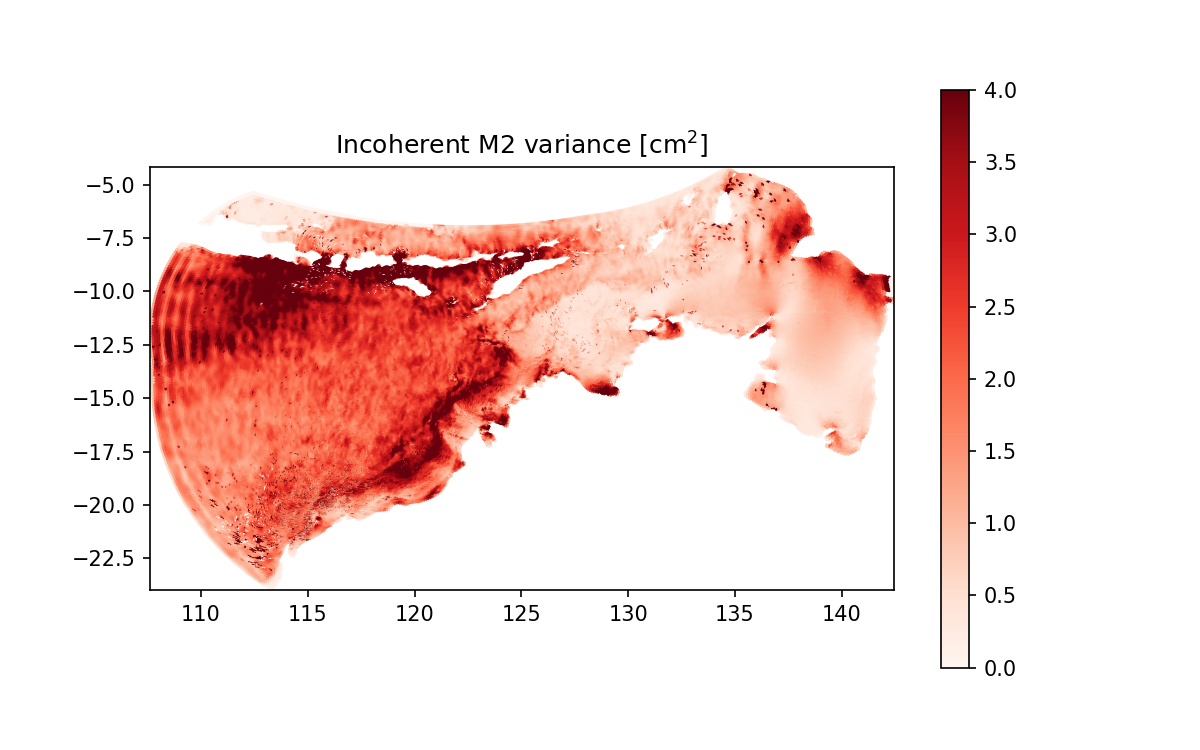

Changing the _FillValue from -999999 to 999999


Text(0.5, 1.0, 'Incoherent M2 variance [cm$^2$]')

In [30]:
plt.figure(figsize=(8,5))
# dsnew.suntans.plotcelldata(np.exp(dsnew['data'].isel(params=0))*1e4, cmap='Reds', vmin=0,vmax=200)
dsnew.suntans.plotcelldata((dsnew['data'].isel(params=0))*100, cmap='Reds', vmin=0,vmax=4)

plt.title('Incoherent M2 variance [cm$^2$]')

<IPython.core.display.Javascript object>


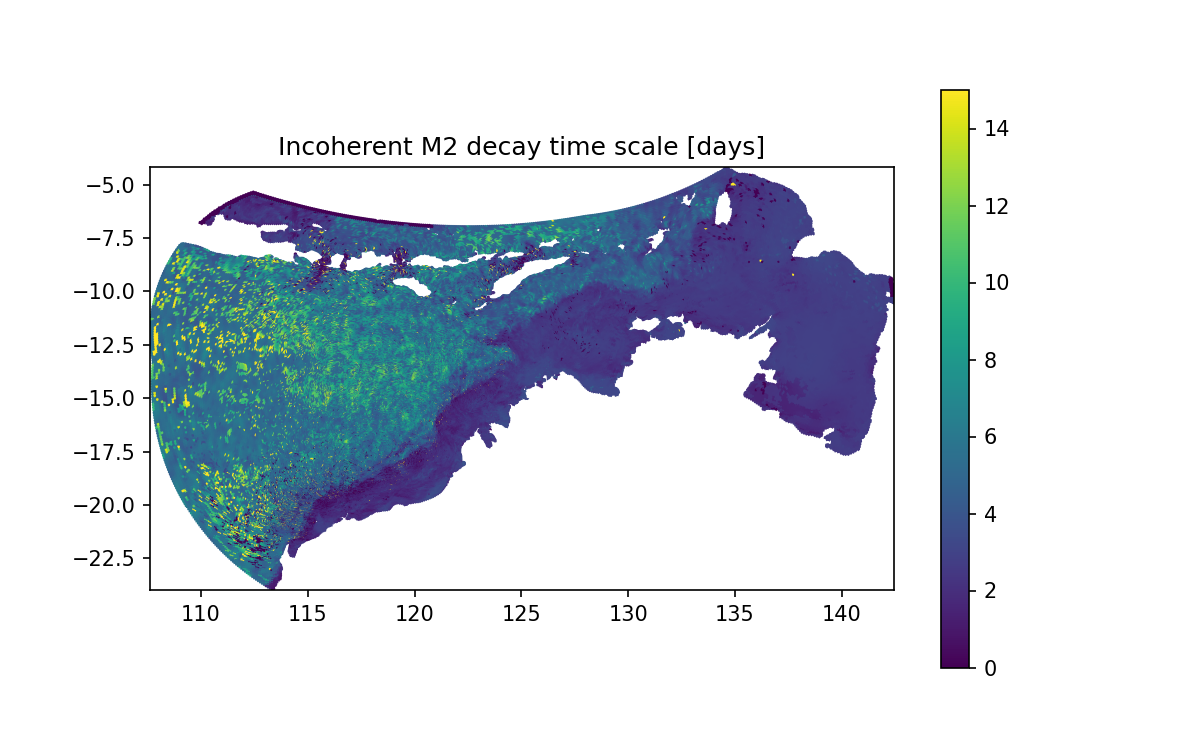

Text(0.5, 1.0, 'Incoherent M2 decay time scale [days]')

In [31]:
plt.figure(figsize=(8,5))
# dsnew.suntans.plotcelldata(np.exp(dsnew['data'].isel(params=1)), cmap='viridis', vmin=0, vmax=40)
dsnew.suntans.plotcelldata((dsnew['data'].isel(params=1)), cmap='viridis', vmin=0, vmax=15)

plt.title('Incoherent M2 decay time scale [days]')

<IPython.core.display.Javascript object>


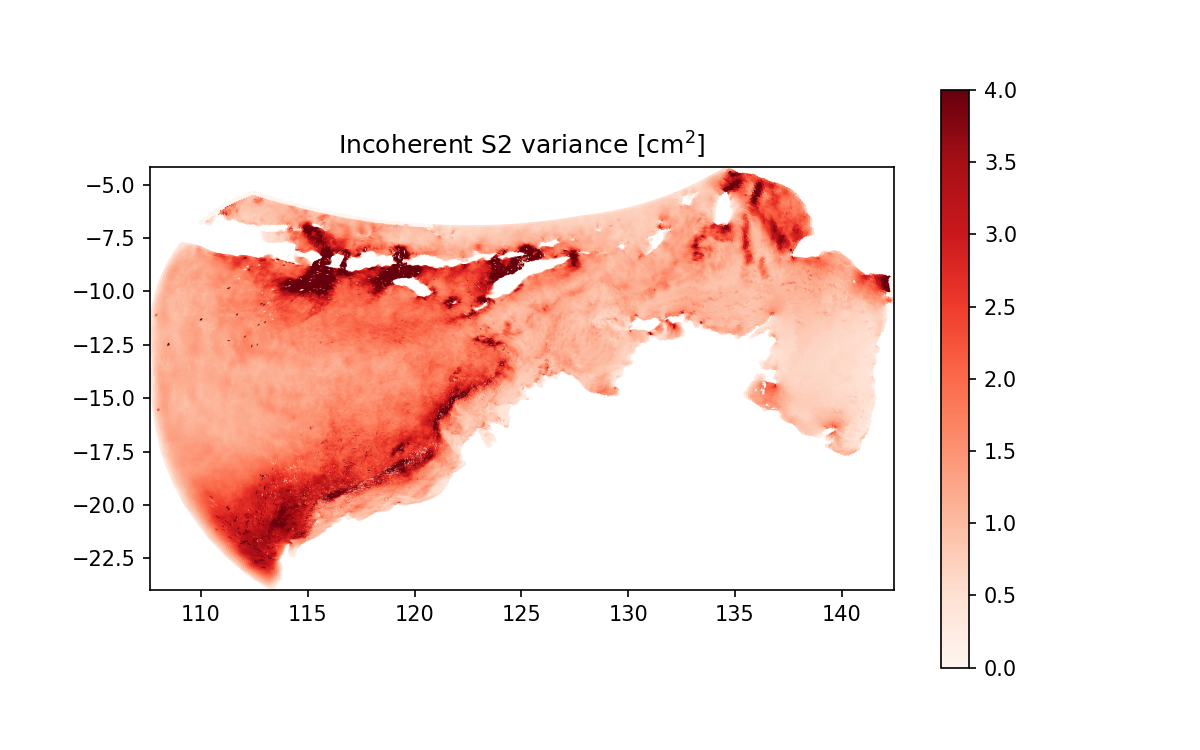

Text(0.5, 1.0, 'Incoherent S2 variance [cm$^2$]')

In [32]:
plt.figure(figsize=(8,5))
dsnew.suntans.plotcelldata((dsnew['data'].isel(params=2))*100, cmap='Reds', vmax=4)
# dsnew.suntans.plotcelldata(np.abs(dsnew['data'].isel(params=2))*1e4, cmap='Reds', vmax=200)

plt.title('Incoherent S2 variance [cm$^2$]')

<IPython.core.display.Javascript object>


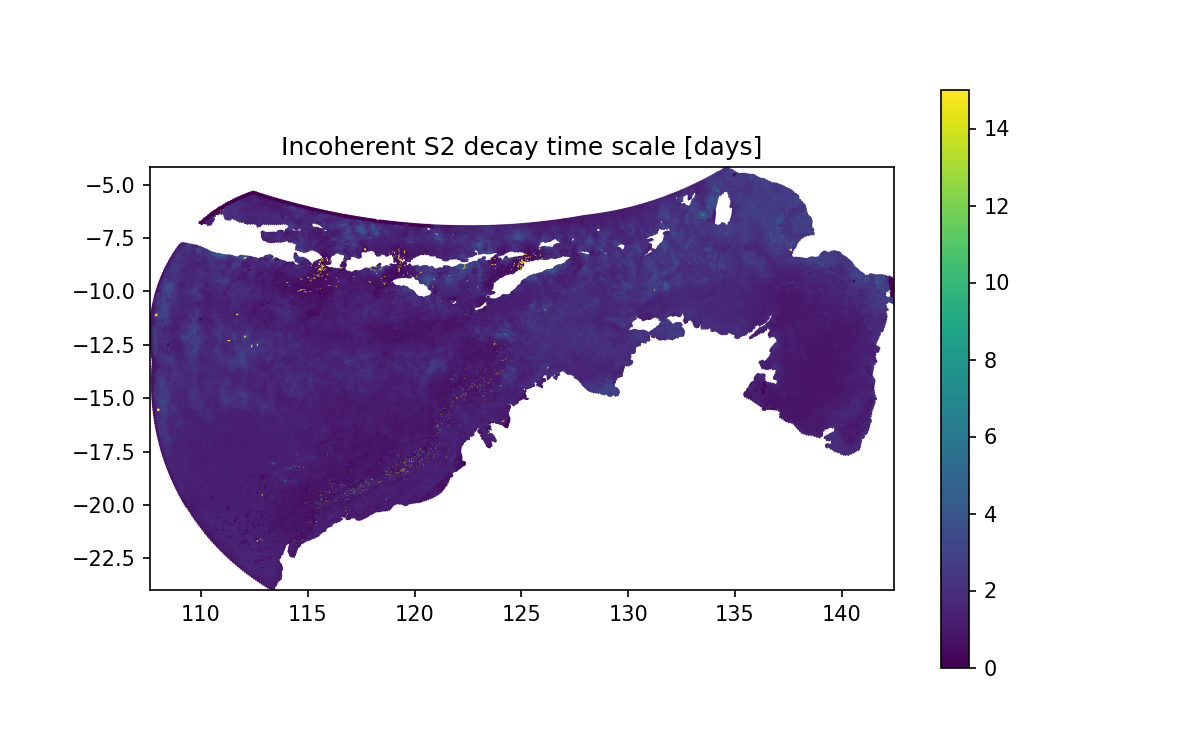

Text(0.5, 1.0, 'Incoherent S2 decay time scale [days]')

In [33]:
plt.figure(figsize=(8,5))
dsnew.suntans.plotcelldata((dsnew['data'].isel(params=3)), cmap='viridis', vmin=0, vmax=15)
plt.title('Incoherent S2 decay time scale [days]')

<IPython.core.display.Javascript object>


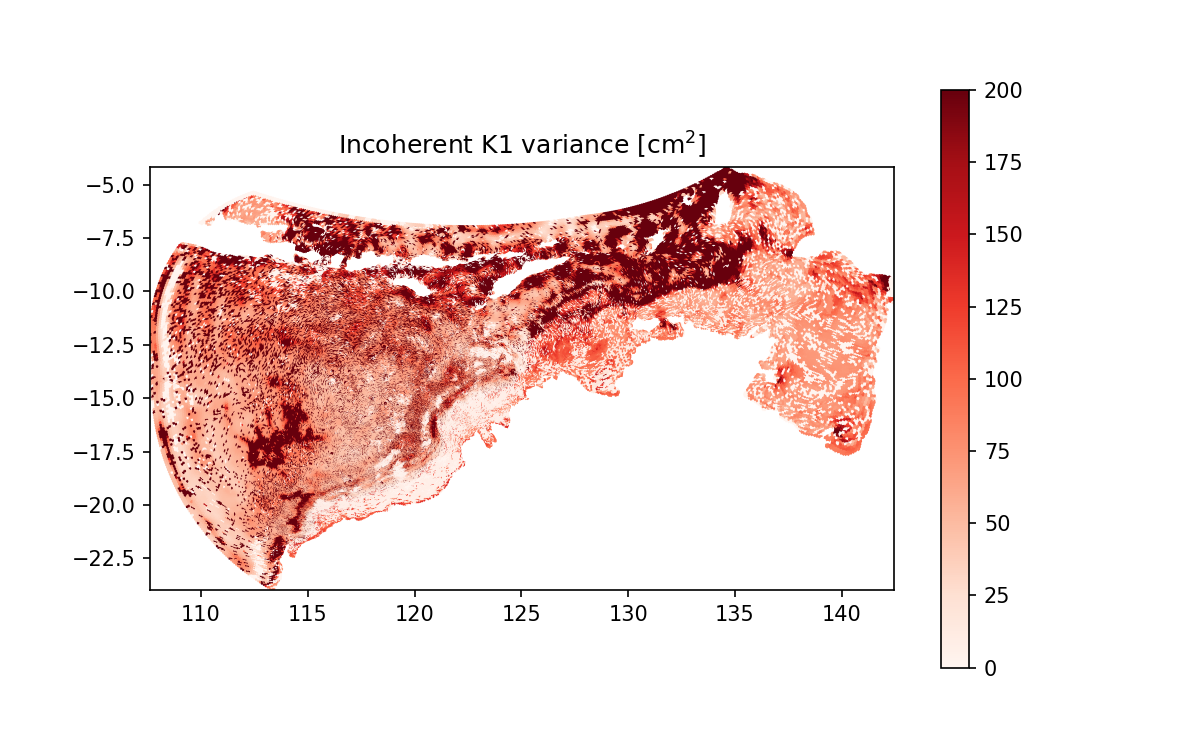

Text(0.5, 1.0, 'Incoherent K1 variance [cm$^2$]')

In [29]:
plt.figure(figsize=(8,5))
dsnew.suntans.plotcelldata(np.exp(dsnew['data'].isel(params=4))*1e4, cmap='Reds', vmin=0, vmax=200)
# dsnew.suntans.plotcelldata(np.abs(dsnew['data'].isel(params=4))*1e4, cmap='Reds', vmin=0, vmax=200)

plt.title('Incoherent K1 variance [cm$^2$]')

<IPython.core.display.Javascript object>


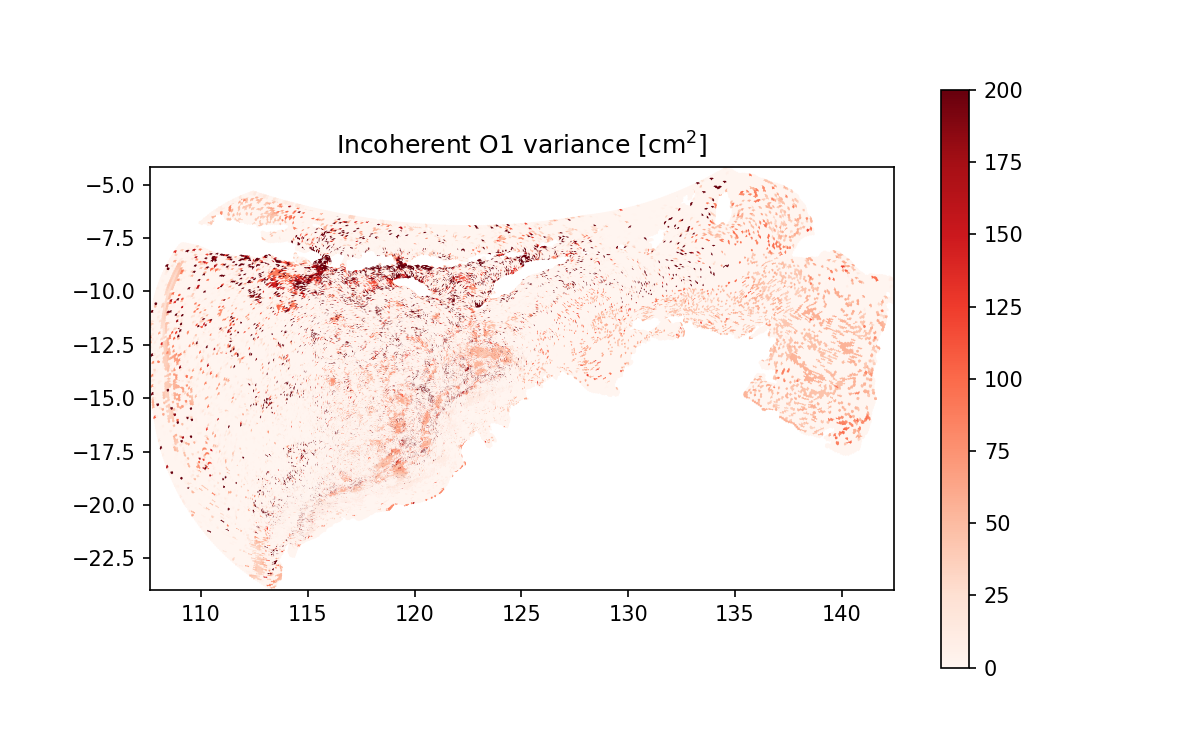

Text(0.5, 1.0, 'Incoherent O1 variance [cm$^2$]')

In [31]:
plt.figure(figsize=(8,5))
dsnew.suntans.plotcelldata(np.exp(dsnew['data'].isel(params=6))*1e4, cmap='Reds', vmax=200)
# dsnew.suntans.plotcelldata(np.abs(dsnew['data'].isel(params=6))*1e4, cmap='Reds', vmax=200)

plt.title('Incoherent O1 variance [cm$^2$]')

In [14]:
inputs = dict(X=X, covfunc=covfunc, covparams_ic=covparams, fmin=fmin, fmax=fmax)


params = xr.apply_ufunc(estimate_spectral_params_whittle_ufunc,
                          y,
                          dask='parallelized',
                          kwargs=inputs,
                          output_dtypes=[y.dtype],
                          input_core_dims=(['time',],),
                          output_core_dims=(['params'],),
                          output_sizes={'params':len(covparams),},
                          vectorize=True,
                         )
params

/tmp/ipykernel_52214/2520862207.py:4: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  params = xr.apply_ufunc(estimate_spectral_params_whittle_ufunc,


<xarray.DataArray (Nc: 225368, params: 8)>
dask.array<transpose, shape=(225368, 8), dtype=float64, chunksize=(1, 8), chunktype=numpy.ndarray>
Dimensions without coordinates: Nc, params

In [ ]:
params = params.compute()

In [ ]:
dsout = ds.drop_vars(['eta_steric_lowpass','eta_steric_bandpass','eta_steric_tidal'])#.isel(Nc=slice(0,10000))
# dsout['data'] = xr.DataArray(params, dims=('params','Nc'), 
#                                            attrs=
#                                 {'long_name':'Estimated covariance model parameters','location':'face',
#                                 'parameter names':paramnames} )
dsout['data'] = params.chunk({'Nc':2000})
dsout['data'].attrs = {'long_name':'Estimated covariance model parameters','location':'face',
                                 'parameter names':paramnames,
                      'covariance function':covfunc.__name__} 
dsout

In [ ]:
# dsout = xr.Dataset({'data':params})
outfile = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_test.nc'
dsout.to_netcdf(outfile, mode='w', compute=True)

In [50]:
dir(covfunc)
covfunc.__name__

'oscillate_M2S2K1O1'

In [261]:
inputs = dict(X=X, covfunc=covfunc, covparams_ic=covparams, fmin=fmin, fmax=fmax)

nparams = len(covparams)
template = xr.DataArray(da.zeros([100, nparams]),
    dims=['Nc', "params",], 
    ).chunk({'Nc':1})
template

<xarray.DataArray 'zeros_like-1862372ee08148fceecbf41459c44158' (Nc: 100,
                                                                 params: 8)>
dask.array<rechunk-merge, shape=(100, 8), dtype=float64, chunksize=(1, 8), chunktype=numpy.ndarray>
Dimensions without coordinates: Nc, params

In [262]:
params = xr.map_blocks(estimate_spectral_params_whittle_ufunc,
                          y_,
                        kwargs=inputs,
                       template=template
                          )
params

<xarray.DataArray 'zeros_like-1862372ee08148fceecbf41459c44158' (Nc: 100,
                                                                 params: 8)>
dask.array<<this-array>-estimate_spectral_params_whittle_ufunc, shape=(100, 8), dtype=float64, chunksize=(1, 8), chunktype=numpy.ndarray>
Dimensions without coordinates: Nc, params

In [53]:
#params.compute()


In [33]:
dsout = xr.Dataset({'data':params})
outfile = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_test.nc'
dsout.to_netcdf(outfile)

KilledWorker: ("('xarray-<this-array>-e2c8e361efb55b03753b98650d235549', 0, 99)", <WorkerState 'tcp://10.253.133.6:35321', status: closed, memory: 0, processing: 513>)

In [193]:
inputs = dict(X=X, covfunc=covfunc, covparams_ic=covparams, fmin=fmin, fmax=fmax)

params = da.map_blocks(estimate_spectral_params_whittle_ufunc,
                        y_.data,
                        drop_axis=0,
                        new_axis=0,
                        dtype=y_.dtype,
                        meta=np.array((), dtype=np.float64)
                        **inputs
                         )
params

dask.array<estimate_spectral_params_whittle_ufunc, shape=(1, 1), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>

In [194]:
params.compute()

KilledWorker: ("('estimate_spectral_params_whittle_ufunc-d487ca2fd22f9eb5adf0072048198264', 0, 0)", <WorkerState 'tcp://10.253.133.6:35923', status: closed, memory: 0, processing: 1>)

In [264]:
from dask import delayed
import dask
from dask import array as da

@delayed
def estimate_spectral_params_whittle_delayed(y, X, covfunc, covparams_ic, fmin, fmax):
    """
    Function that xarray.apply_func can handle
    """
    return estimate_spectral_params_whittle(y, X, covfunc, covparams_ic, fmin, fmax)
    #return y*2


In [18]:
X, covfunc, covparams, fmin, fmax


(array([0.00000000e+00, 4.16666667e-02, 8.33333333e-02, ...,
        3.50916667e+02, 3.50958333e+02, 3.51000000e+02]),
 <function __main__.oscillate_M2S2K1O1(x, xpr, params, lt=[0.517525050851839, 0.5, 0.9972695689985752, 1.0758059026974014], itfunc=<function matern32 at 0x14b7d66a2440>)>,
 (0.007, 10.0, 0.008, 10.0, 0.003, 10.0, 0.006, 10.0),
 0.5,
 2.7)

In [28]:
data = [delayed(y.isel(Nc=ii)*19) for ii in range(10)]
data_ = client.compute(data)

In [29]:
data_

[<Future: finished, type: xarray.core.dataarray.DataArray, key: DataArray-cdccd950-3717-4a28-92d2-d0976259f5e2>,
 <Future: finished, type: xarray.core.dataarray.DataArray, key: DataArray-c62558f3-969f-4a1d-9a96-1d6b48535e69>,
 <Future: finished, type: xarray.core.dataarray.DataArray, key: DataArray-2d7a76e6-d5b3-4ee0-aa4b-e7458539c3fe>,
 <Future: finished, type: xarray.core.dataarray.DataArray, key: DataArray-994488c8-1acc-4748-a14b-9b8e98dc2eb3>,
 <Future: finished, type: xarray.core.dataarray.DataArray, key: DataArray-7828eb14-4852-42c0-bb69-c56bb9d5a4c3>,
 <Future: finished, type: xarray.core.dataarray.DataArray, key: DataArray-021c4eb2-ea13-4341-87be-4b573ddd3c1f>,
 <Future: finished, type: xarray.core.dataarray.DataArray, key: DataArray-47d42795-2fc0-49a4-8e8d-f1fb72f60d06>,
 <Future: finished, type: xarray.core.dataarray.DataArray, key: DataArray-03394b2c-872c-40e0-8d70-1eb4d5e8930a>,
 <Future: finished, type: xarray.core.dataarray.DataArray, key: DataArray-0d506f4d-b82e-4684-97f

In [265]:
delayed_objs = [estimate_spectral_params_whittle_delayed(y_.isel(Nc=ii), X, covfunc, covparams, fmin, fmax) 
                for ii in range(10)]
delayed_objs

[Delayed('estimate_spectral_params_whittle_delayed-949d7721-22b9-4294-8091-ad6535864c8d'),
 Delayed('estimate_spectral_params_whittle_delayed-5d55c605-5732-4c0c-a586-031afd0c5b47'),
 Delayed('estimate_spectral_params_whittle_delayed-b99e410b-cc14-45dd-8ede-6411d4d8cc15'),
 Delayed('estimate_spectral_params_whittle_delayed-e4227e40-ff71-41b0-903e-b16f8ea7e4f6'),
 Delayed('estimate_spectral_params_whittle_delayed-a404b027-dc8d-4f55-a3fa-b4217c5e3e82'),
 Delayed('estimate_spectral_params_whittle_delayed-700f530d-b38e-4eea-9d96-55d010752ee6'),
 Delayed('estimate_spectral_params_whittle_delayed-a64708a5-842f-4008-beb6-d03cb23b1111'),
 Delayed('estimate_spectral_params_whittle_delayed-eae278e1-a303-4602-aebb-f77455212a7b'),
 Delayed('estimate_spectral_params_whittle_delayed-8cec5d8a-63f6-4883-9efd-3acb89a910b6'),
 Delayed('estimate_spectral_params_whittle_delayed-8f50073e-5b22-44e2-b805-27df99104cd0')]

In [266]:
# (delayed_objs, (5,), dtype=float
y_est=client.compute(delayed_objs)
y_est

/opt/conda/lib/python3.10/site-packages/distributed/worker.py:4798: UserWarning: Large object of size 6.50 MiB detected in task graph: 
  ([["('getitem-52faf727e935fea46901257fb39c4b3b', 0 ... a=np.ndarray>>)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


[<Future: pending, key: estimate_spectral_params_whittle_delayed-949d7721-22b9-4294-8091-ad6535864c8d>,
 <Future: pending, key: estimate_spectral_params_whittle_delayed-5d55c605-5732-4c0c-a586-031afd0c5b47>,
 <Future: pending, key: estimate_spectral_params_whittle_delayed-b99e410b-cc14-45dd-8ede-6411d4d8cc15>,
 <Future: pending, key: estimate_spectral_params_whittle_delayed-e4227e40-ff71-41b0-903e-b16f8ea7e4f6>,
 <Future: pending, key: estimate_spectral_params_whittle_delayed-a404b027-dc8d-4f55-a3fa-b4217c5e3e82>,
 <Future: pending, key: estimate_spectral_params_whittle_delayed-700f530d-b38e-4eea-9d96-55d010752ee6>,
 <Future: pending, key: estimate_spectral_params_whittle_delayed-a64708a5-842f-4008-beb6-d03cb23b1111>,
 <Future: pending, key: estimate_spectral_params_whittle_delayed-eae278e1-a303-4602-aebb-f77455212a7b>,
 <Future: pending, key: estimate_spectral_params_whittle_delayed-8cec5d8a-63f6-4883-9efd-3acb89a910b6>,
 <Future: pending, key: estimate_spectral_params_whittle_delayed

In [267]:
y_est[0]

<Future: error, key: estimate_spectral_params_whittle_delayed-949d7721-22b9-4294-8091-ad6535864c8d>

In [123]:
# da.array(delayed_objs, (5,8), )
#dask.compute

NotImplementedError: Can not use auto rechunking with object dtype. We are unable to estimate the size in bytes of object data

In [53]:
estimate_spectral_params_whittle(y.isel(Nc=0), X, covfunc, covparams, fmin, fmax)

/tmp/ipykernel_121310/1164739196.py:11: RuntimeWarning: invalid value encountered in log
  return - 2 * np.sum(np.log(S_boch[idx_boch]) + I[idx]/S_boch[idx_boch])
/opt/conda/lib/python3.10/site-packages/gptide/cov.py:51: RuntimeWarning: overflow encountered in exp
  return (1 + fac2/l)*np.exp(-fac2/l)
/opt/conda/lib/python3.10/site-packages/gptide/cov.py:51: RuntimeWarning: overflow encountered in multiply
  return (1 + fac2/l)*np.exp(-fac2/l)


array([5.51626179e-03, 5.97922785e+00, 1.56330190e-03, 1.52664123e+01,
       1.31599616e-10, 6.39997142e+01, 4.54301569e-03, 7.04747982e-01])

In [56]:
futures = client.compute(delayed_objs)

In [67]:
da.from_delayed(delayed_objs, (8,))

AttributeError: 'list' object has no attribute 'key'

In [62]:
da.from_delayed?

In [79]:
client.restart()

<Client: 'tcp://10.253.133.84:8786' processes=2 threads=32, memory=53.74 GiB>